In [1]:
!pip3 install anndata
!pip3 install scanpy
!pip3 install matplotlib

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap

# Download necessary files
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103967

We're interested in the files corresponding to cells "CD45- Epcam+ (4-6 weeks)

In [3]:
# Download CD45- EpCAM+ cells
gsm_list = [
            ('7017', '1395'),
            ('7018', '1396'),
            ('7019', '1398'),
            ('7020', '1458'),
            ('7021', '1459'),
            ('7022', '1539'),
            ('7023', '1540'),
            ('7024', '1541'),
            ('7025', '1542'),
            ('7026', '1544'),
            ('7027', '1545'),
            ('7028', '1546'),
            ('7029', '1646'),
            ('7030', '1647'),
            ('7031', '1648'),
            ('7032', '1649'),
            ('7033', '1751'),
            ('7034', '1753'),
            ('7035', '1792'),
            ('7036', '1793'),
            ('7037', '1795'),
]

for gsm, ab in gsm_list:
  !wget -c -nv $f'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM278{gsm}/suppl/GSM278{gsm}_AB{ab}.txt.gz'
  !gzip -f -d $f'GSM278{gsm}_AB{ab}.txt.gz'

2024-12-05 23:36:44 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM2787017/suppl/GSM2787017_AB1395.txt.gz [484276/484276] -> "GSM2787017_AB1395.txt.gz" [1]
2024-12-05 23:36:44 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM2787018/suppl/GSM2787018_AB1396.txt.gz [398303/398303] -> "GSM2787018_AB1396.txt.gz" [1]
2024-12-05 23:36:44 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM2787019/suppl/GSM2787019_AB1398.txt.gz [490402/490402] -> "GSM2787019_AB1398.txt.gz" [1]
2024-12-05 23:36:45 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM2787020/suppl/GSM2787020_AB1458.txt.gz [393417/393417] -> "GSM2787020_AB1458.txt.gz" [1]
2024-12-05 23:36:45 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM2787021/suppl/GSM2787021_AB1459.txt.gz [482002/482002] -> "GSM2787021_AB1459.txt.gz" [1]
2024-12-05 23:36:45 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2787nnn/GSM2787022/suppl/GSM2787022_AB1539.txt.gz [348159/348159] -> "GSM2787022_AB1539.txt.

# Unite all files into 1 big file, getting a matrix 34016 rows × 8064 columns

In [4]:
from functools import reduce
def read_dataframe(gsm_ab):
    gsm, ab = gsm_ab
    return pd.read_csv(f'/content/GSM278{gsm}_AB{ab}.txt', sep='\t')

dfs = map(read_dataframe, gsm_list)
counts = reduce(lambda acc, df: pd.concat([acc, df], axis=1), dfs)
counts

,W291665,W291666,W291667,W291668,W291669,W291670,W291671,W291672,W291673,W291674,...,W432007,W432008,W432009,W432010,W432011,W432012,W432013,W432014,W432015,W432016
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007C21Rik,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007L01Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610007P08Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007P14Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
snoZ159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snoZ178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snoZ39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snoZ40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Gene marker expression

Compare cell IDs (columns from files in GEO) with IDs from (https://drive.google.com/file/d/1OaqaGULwMUlQ7SkdADOFMW5NrQbGtA3G/view?usp=sharing) 




In [5]:
# choose only cells from the provided file
!gdown 1OaqaGULwMUlQ7SkdADOFMW5NrQbGtA3G
def filter_counts_by_cell_ids(counts, cell_ids):
    return counts.loc[:, counts.columns.isin(cell_ids)]
cells = pd.read_csv("thymus_epithel_clusts.txt", sep='\t', index_col=0)
cell_ids = cells.index
counts = filter_counts_by_cell_ids(counts, cell_ids)

Downloading...
From: https://drive.google.com/uc?id=1OaqaGULwMUlQ7SkdADOFMW5NrQbGtA3G
To: /content/thymus_epithel_clusts.txt
100% 42.8k/42.8k [00:00<00:00, 41.2MB/s]


In [6]:
counts

,W291665,W291666,W291668,W291670,W291676,W291677,W291679,W291680,W291683,W291685,...,W431994,W431996,W432001,W432003,W432005,W432006,W432008,W432009,W432011,W432013
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007C21Rik,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
0610007L01Rik,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
0610007P08Rik,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
0610007P14Rik,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
snoZ159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snoZ178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snoZ39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
snoZ40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
markers = ['Ctsl', 'Psmb11', 'Prss16', 'Ascl1', 'Sox4', 'Ccl21a', 'Apoe', 'Ly6a', 'Ccl21c', 'Aire', 'Hdc', 'Ubd', \
           'Cd52', 'Ccl20', 'Serpinb6a', 'Ly6d', 'Pigr', 'Car8', 'Lcn2', 'Trpm5', 'Avil', 'Gnb3', 'Lrmp']

Using RPM (reads per million) because we don't have data on gene length, which is necessary for TPM, RPKM and FPKM. More here: https://www.biostars.org/p/273537/

In [8]:
# normalization (TPM (transcripts per million), FPKM (fragments per kilobase of transcript per million fragments mapped),
# normalized counts using coefficient of variation, intraclass correlation coefficient).
data_normalized = counts / counts.sum() * 10**6


Get heatmap:

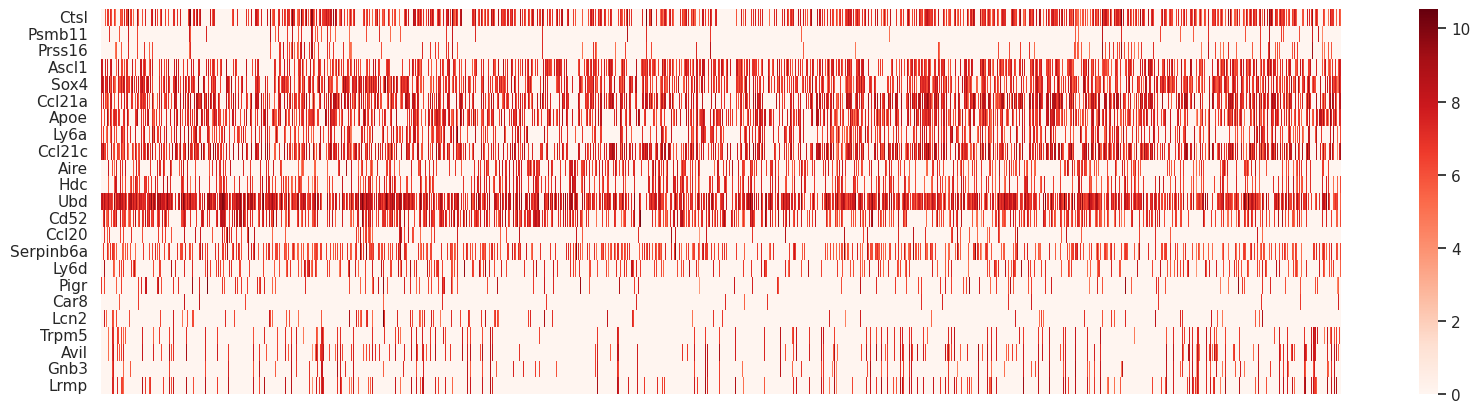

In [9]:
data_normalized_markers = data_normalized.loc[markers]
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.heatmap(np.log(data_normalized_markers + 1), yticklabels=True, xticklabels=False, cmap='Reds')
plt.show()

# Visualize all 2341 cells on  UMAP and PCA

We will use anndata (https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html)and  scanpy (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [10]:
import scanpy
counts_norm = data_normalized
adata = ad.AnnData(counts_norm.T)
scanpy.pp.log1p(adata)
adata.var_names = list(counts_norm.index)
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]

In [11]:
# add to metadata cell type provided by authors

cells_type_data = cells.loc[data_normalized.columns, "group"]


In [12]:
# cells_type_data - cell type provided by authors
adata.obs["cell_type"] = list(cells_type_data)

In [13]:
scanpy.pp.pca(adata, n_comps=50)

In [14]:
colors = ['red', 'green', 'black', 'pink', 'orange']
cmap = get_cmap(ListedColormap(colors))

<ipython-input-14-06ed9cd57294>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(ListedColormap(colors))


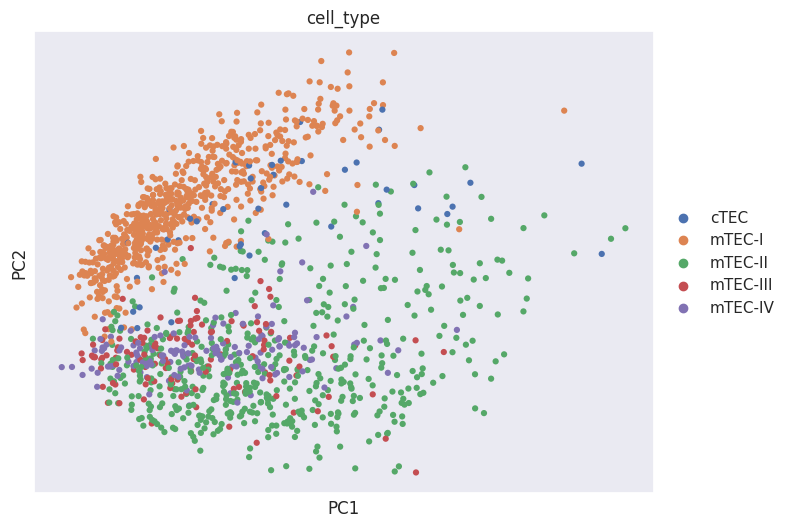

In [15]:
f, ax = plt.subplots(figsize=(8, 6))
scanpy.pl.pca(adata, color=['cell_type'], colorbar_loc=None, color_map=cmap, ax=ax)

In [16]:
scanpy.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(adata)

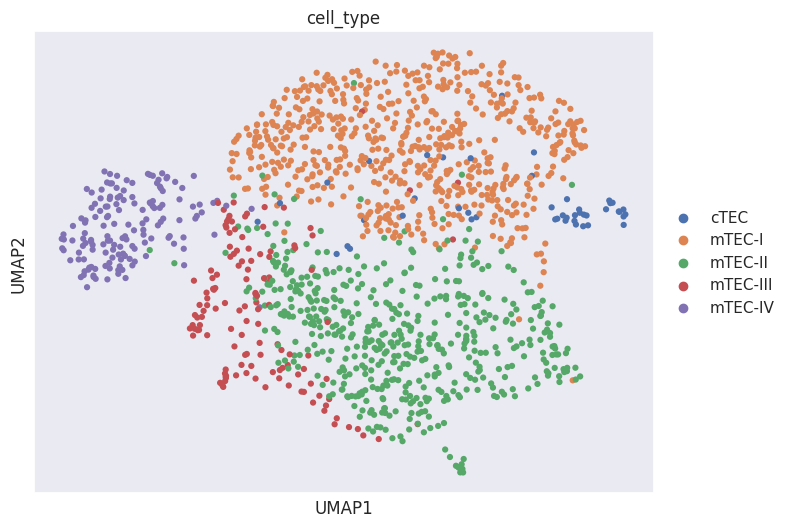

In [17]:
f, ax = plt.subplots(figsize=(8, 6))
scanpy.pl.umap(adata, color=['cell_type'], colorbar_loc=None, color_map=cmap, ax=ax)
plt.show()

UMAP was generally better for clusterization than PCA, which clustered everything together with the exception of mTEC-I

**Бонус**

In [18]:
! gdown 1jDnstauvQvZsm_89saoUKTVykSicZPc2
! gdown 1jMW6oEUJLk2snJOnxgRGBwVOjcmYrThe


Downloading...
From: https://drive.google.com/uc?id=1jDnstauvQvZsm_89saoUKTVykSicZPc2
To: /content/SRR2038194.gene_name.counts
100% 585k/585k [00:00<00:00, 31.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jMW6oEUJLk2snJOnxgRGBwVOjcmYrThe
To: /content/SRR2038195.gene_name.counts
100% 590k/590k [00:00<00:00, 15.8MB/s]


In [19]:
SRR2038194 = pd.read_csv("SRR2038194.gene_name.counts", sep='\t', names=["Gene", "Counts"], index_col=0)
SRR2038195 = pd.read_csv("SRR2038195.gene_name.counts", sep='\t', names=["Gene", "Counts"], index_col=0)


In [20]:
print(SRR2038194, SRR2038195)

            Counts
Gene              
Gnai3         3767
Pbsn             0
Cdc45          281
H19            640
Scml2           58
...            ...
AC156032.1       1
BX681418.1       0
AL606917.1       0
CT485612.1       1
AC158307.1       0

[55291 rows x 1 columns]             Counts
Gene              
Gnai3         4966
Pbsn             4
Cdc45          392
H19           1220
Scml2           85
...            ...
AC156032.1       2
BX681418.1       0
AL606917.1       3
CT485612.1       0
AC158307.1       0

[55291 rows x 1 columns]


In [21]:
SRR2038194_normalized = SRR2038194 / SRR2038194.sum() * 10**6
SRR2038195_normalized = SRR2038195 / SRR2038195.sum() * 10**6
print(SRR2038194_normalized, SRR2038195_normalized)


                Counts
Gene                  
Gnai3       169.326529
Pbsn          0.000000
Cdc45        12.630941
H19          28.767979
Scml2         2.607098
...                ...
AC156032.1    0.044950
BX681418.1    0.000000
AL606917.1    0.000000
CT485612.1    0.044950
AC158307.1    0.000000

[55291 rows x 1 columns]                 Counts
Gene                  
Gnai3       154.409877
Pbsn          0.124374
Cdc45        12.188617
H19          37.933961
Scml2         2.642940
...                ...
AC156032.1    0.062187
BX681418.1    0.000000
AL606917.1    0.093280
CT485612.1    0.000000
AC158307.1    0.000000

[55291 rows x 1 columns]


In [22]:
mean_bulk_norm = pd.concat([SRR2038194_normalized, SRR2038195_normalized], axis=1).mean(axis=1)


 For each gene we take average RPM for all scRNA-seq cells
(subgroup mTEC-IV)

In [23]:
def get_mtec_iv_cells(cells):
    return cells[cells['group'] == 'mTEC-IV'].index

def get_mark(mtec_iv_cells, data_normalized):
    return set(mtec_iv_cells) & set(data_normalized.columns)

def calculate_mean(data_normalized, mark):
    return data_normalized.loc[:, list(mark)].mean(axis=1)
mtec_iv_cells = get_mtec_iv_cells(cells)
mark = get_mark(mtec_iv_cells, data_normalized)
mean_scRNAseq_normalized = calculate_mean(data_normalized, mark)

In [24]:
!cat SRR2038194.gene_name.counts | grep Ccl21c
!cat SRR2038195.gene_name.counts | grep Ccl21c
!cat SRR2038195.gene_name.counts | grep Lrmp
!cat SRR2038194.gene_name.counts | grep Lrmp

Lrmp	482
Lrmp	372


In [25]:
markers_without_Ccl21c = ['Ctsl', 'Psmb11', 'Prss16', 'Ascl1', 'Sox4', 'Ccl21a', 'Apoe', 'Ly6a', 'Aire', 'Hdc', 'Ubd', \
           'Cd52', 'Ccl20', 'Serpinb6a', 'Ly6d', 'Pigr', 'Car8', 'Lcn2', 'Trpm5', 'Avil', 'Gnb3', 'Lrmp']

In [26]:
mtec_iv_cells

Index(['W160351', 'W160358', 'W160368', 'W160393', 'W160418', 'W160434',
       'W160452', 'W160465', 'W160470', 'W160495',
       ...
       'W271245', 'W271275', 'W271278', 'W270946', 'W270950', 'W270951',
       'W270962', 'W271000', 'W271011', 'W271089'],
      dtype='object', length=279)

In [27]:
mark

{'W291694',
 'W291696',
 'W291702',
 'W291709',
 'W291712',
 'W291746',
 'W291795',
 'W291804',
 'W291830',
 'W291866',
 'W291894',
 'W291916',
 'W291936',
 'W291985',
 'W292001',
 'W292012',
 'W292258',
 'W292267',
 'W292283',
 'W292292',
 'W292346',
 'W292349',
 'W292356',
 'W292357',
 'W292358',
 'W292363',
 'W292399',
 'W292404',
 'W292411',
 'W292420',
 'W314716',
 'W314731',
 'W314799',
 'W314850',
 'W314853',
 'W314867',
 'W314885',
 'W314903',
 'W314916',
 'W314922',
 'W314930',
 'W314939',
 'W314957',
 'W314977',
 'W314998',
 'W315009',
 'W315010',
 'W315013',
 'W315016',
 'W315041',
 'W315056',
 'W315063',
 'W339737',
 'W340060',
 'W340128',
 'W340129',
 'W340213',
 'W340405',
 'W340418',
 'W340653',
 'W340657',
 'W340703',
 'W340779',
 'W340916',
 'W340988',
 'W341064',
 'W341120',
 'W341132',
 'W341189',
 'W341193',
 'W378460',
 'W378467',
 'W378547',
 'W378560',
 'W378575',
 'W378583',
 'W378599',
 'W378612',
 'W378623',
 'W378626',
 'W378627',
 'W378636',
 'W378638',
 'W3

In [28]:
mean_scRNAseq_normalized

,0
0610005C13Rik,0.000000
0610007C21Rik,30.192320
0610007L01Rik,51.624569
0610007P08Rik,8.036581
0610007P14Rik,46.598275
...,...
snoZ159,0.000000
snoZ178,0.000000
snoZ39,5.070840
snoZ40,0.000000


In [29]:
def get_common_genes(bulk_genes, scRNAseq_genes):
    return set(bulk_genes) & set(scRNAseq_genes)

def prepare_mean_normalized(bulk_data, scRNAseq_data, common_genes):
    common_genes_list = list(common_genes)
    return pd.DataFrame({
        'Bulk': bulk_data.loc[common_genes_list],
        'Single-cell': scRNAseq_data.loc[common_genes_list]
    })

common_genes = get_common_genes(mean_bulk_norm.index, mean_scRNAseq_normalized.index)
mean_normalized = prepare_mean_normalized(mean_bulk_norm, mean_scRNAseq_normalized, common_genes)

<Axes: xlabel='Bulk', ylabel='Single-cell'>

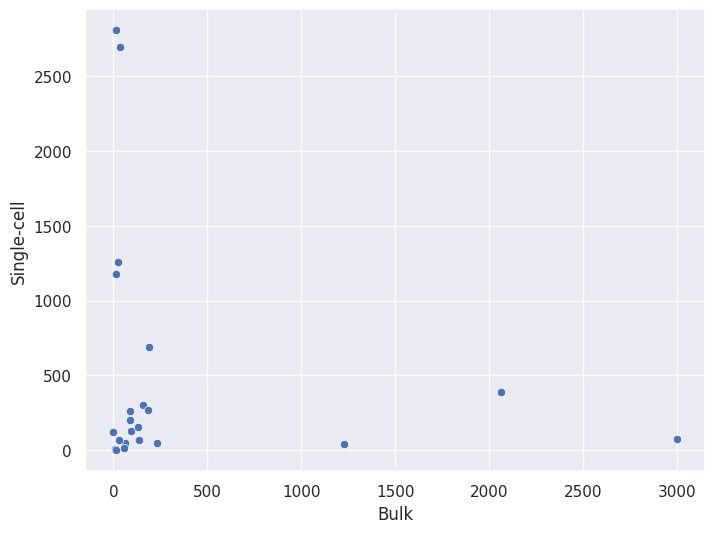

In [30]:
f, ax = plt.subplots(figsize=(8, 6))
scatter_data = mean_normalized.loc[markers_without_Ccl21c]
sns.scatterplot(data=scatter_data, x="Bulk", y="Single-cell", ax=ax)

~14 genes - more than half - have similar expression (see bottom left corner of the graph)

In [31]:

def calculate_mean_expression(mean_normalized):
    mean_normalized['mean'] = mean_normalized[['Bulk', 'Single-cell']].mean(axis=1)
    return mean_normalized

def get_top_expressed_genes(mean_normalized, top_n=170):
    sorted_genes = mean_normalized.sort_values('mean', ascending=False)
    return sorted_genes.head(top_n)

mean_normalized = calculate_mean_expression(mean_normalized)
mean_normalized_max_mean = get_top_expressed_genes(mean_normalized, top_n=170)
genes_max_mean = list(mean_normalized_max_mean.index)

<Axes: xlabel='Bulk', ylabel='Single-cell'>

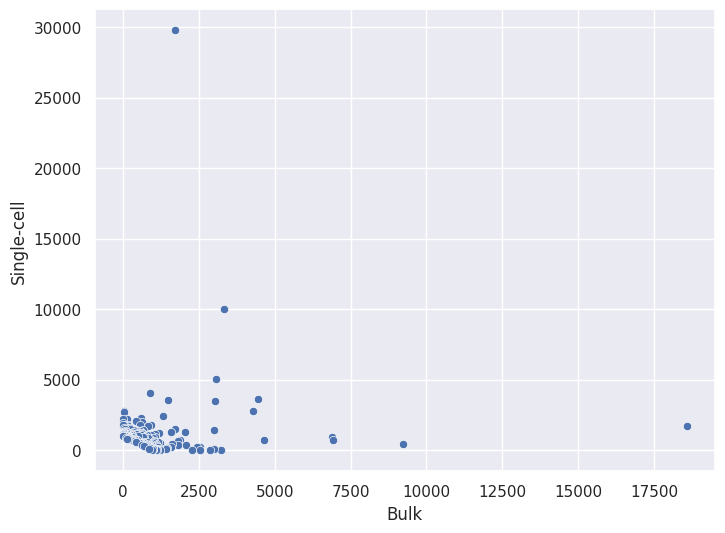

In [32]:
f, ax = plt.subplots(figsize=(8, 6))
scatter_data = mean_normalized.loc[genes_max_mean]
sns.scatterplot(data=scatter_data, x="Bulk", y="Single-cell", ax=ax)

It looks like the vast majority of genes have similar expression both in bulk and scRNA; for a small number of genes the difference is significant

In [33]:
!pip install pydeseq2==0.5.0rc2

In [62]:
import pydeseq2

In [59]:
from pydeseq2 import dds

In [1]:
data = mean_normalized[['Bulk', 'Single-cell']].T
data.columns = ['Bulk', 'Single-cell']
deseq_dataset = dds(data, design='~ 1')
dds = pydeseq2.dds.estimateSizeFactors(dds)
results = pydeseq2.dds.nbinomTest(dds, 'Bulk', 'Single-cell')
significant_genes = results[results['pvalue'] < 0.05]

print(f"Total gene count: {len(data)}")
print(f"Amount of genes with similar expression: {len(significant_genes)}")


NameError: name 'mean_normalized' is not defined

In [56]:
a_data = scanpy.AnnData(mean_normalized)

a_data.obs['condition'] = ['Bulk'] * len(mean_normalized) + ['Single-cell'] * len(mean_normalized)

scanpy.tl.rank_genes_groups(a_data, groupby='condition', method='t-test')

results = a_data.uns['rank_genes_groups']
group_names = results['names'].dtype.names

significant_genes = {group: results['names'][group] for group in group_names}

for group in group_names:
    print(f"Number of significant genes for {group}: {len(significant_genes[group])}")

ValueError: Length of values (56214) does not match length of index (28107)

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

DESeq2 = importr('DESeq2')

dds = DESeq2.DESeqDataSet(countData=mean_normalized.loc[genes_max_mean, ['Bulk', 'Single-cell']], design=~0+condition)

dds = DESeq2.DESeq(dds)

res = DESeq2.results(dds, contrast='condition')

significant_genes = res[res.rx2('padj') < 0.05]

similar_genes = len(genes_max_mean) - len(significant_genes)

print(f'Number of genes with significant difference in expression: {len(significant_genes)}')
print(f'Number of genes with similar expression: {similar_genes}')


ModuleNotFoundError: No module named 'rpy2'